In [37]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from DataGenerator import *
from AnalyticalSolution import *
from Switcher import *
from Calculator import *
from GradientDescent import *
from ConjugateGradient import *

%matplotlib inline
sns.set(palette="Set2")

In [38]:
# 超参数
TRAIN_NUM = 15 # 训练集规模
VALIDATION_NUM = 100 # 验证集规模
TEST_NUM = 1000 # 测试集规模
ORDER = 6 # 阶数
X_LEFT = 0 # 左界限
X_RIGHT = 1 # 右界限
NOISE_SCALE = 0.25 # 噪音标准差
LEARNING_RATE = 0.1 # 梯度下降学习率
DELTA = 1e-6 # 优化残差界限
W_SOLUTION = pd.DataFrame() # 不同方法的w解

def base_func(x):
    """原始函数
    """
    return np.sin(2 * np.pi * x)

# 训练集
train_data = get_data(
    x_range=(X_LEFT, X_RIGHT),
    sample_num=TRAIN_NUM,
    base_func=base_func,
    noise_scale=NOISE_SCALE,
)
X_TRAIN = train_data["X"]
Y_TRAIN = train_data["Y"]

# 验证集
X_VALIDATION = np.linspace(X_LEFT, X_RIGHT, VALIDATION_NUM)
Y_VALIDATION = base_func(X_VALIDATION)

# 测试集
X_TEST = np.linspace(X_LEFT, X_RIGHT, TEST_NUM)
Y_TEST = base_func(X_TEST)

train_data

,X,Y
0,0.000000,-0.315513
1,0.071429,0.796137
2,0.142857,0.736210
3,0.214286,0.828218
4,0.285714,0.889926
5,0.357143,0.506895
6,0.428571,0.063076
7,0.500000,-0.118981
8,0.571429,-0.802267
9,0.642857,-0.878678


# 可视化拟合结果

In [39]:
def show_train_data(x_train, y_train):
    plt.scatter(x=x_train, y=y_train, color="white", edgecolors="purple")

In [40]:
def show_test_data(x_test, y_test):
    plt.plot(x_test, y_test, linewidth=2, color="black", linestyle="-.")

In [41]:
def show_comparation(x, y1, label1, y2, label2):
    """可视化两个函数
    """
    d = pd.DataFrame(
        np.concatenate(
            (
                np.transpose([X_TEST, y1, [label1] * TEST_NUM]),
                np.transpose([X_TEST, y2, [label2] * TEST_NUM]),
            )
        ),
        columns=["X", "Y", "type"],
    )
    d[["X", "Y"]] = d[["X", "Y"]].astype("float")
    sns.lineplot(x="X", y="Y", data=d, hue="type")
    plt.title("ORDER = " + str(ORDER) + ", TRAIN_NUM = " + str(TRAIN_NUM))

# 解析解

In [42]:
def get_y_pred_by_analytical(x_train, y_train, x, with_penalty=False, lambda_penalty=None):
    assert not with_penalty or lambda_penalty is not None  # 有惩罚项时，lambda不为空
    x_vec, t_vec = x_train, y_train
    w_vec = (
        get_params_with_penalty(
            x_matrix=get_x_matrix(x_vec, order=ORDER),
            t_vec=t_vec,
            lambda_penalty=lambda_penalty,
        )
        if with_penalty
        else get_params(x_matrix=get_x_matrix(x_vec, order=ORDER), t_vec=t_vec)
    )
    return np.dot(get_x_matrix(x, order=ORDER), w_vec), w_vec

# 不带惩罚项解析解

In [43]:
y_pred, w_vec = get_y_pred_by_analytical(x_train=X_TRAIN, y_train=Y_TRAIN, x=X_TEST, with_penalty=False)
W_SOLUTION["Analytical_Without_Penalty"] = w_vec

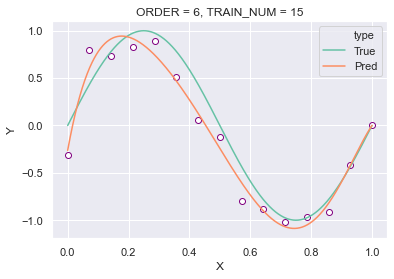

In [44]:
show_comparation(x=X_TEST, y1=Y_TEST, label1="True", y2=y_pred, label2="Pred")
show_train_data(x_train=X_TRAIN, y_train=Y_TRAIN)

# 带惩罚项解析解

In [45]:
def show_lambda_error(error_ln_lambda):
    data = pd.DataFrame(error_ln_lambda, columns=["$ln{\lambda}$", "$E_{rms}$", "type"])
    sns.lineplot(x="$ln{\lambda}$", y="$E_{rms}$", data=data, hue="type")
    idxmin = error_ln_lambda[data[data["type"]=="VALIDATION"]["$E_{rms}$"].idxmin()]
    plt.title(label=("Min: $e^{" + str(int(idxmin[0])) + "}, " + "{:.3f}".format(idxmin[1]) + "$"))
    return np.power(np.e, idxmin[0]), idxmin[1]

In [46]:
error_ln_lambda = []
for i in range(-50, 0):
    y_pred, w_vec = get_y_pred_by_analytical(
        x_train=X_TRAIN,
        y_train=Y_TRAIN,
        x=X_TRAIN,  # 训练集
        with_penalty=True,
        lambda_penalty=np.exp(i),
    )
    error_ln_lambda.append(
        [i, calc_e_rms(y_pred=y_pred, y_true=Y_TRAIN), "TRAIN"]
    )  # 训练集上的根均方误差
    y_pred, w_vec = get_y_pred_by_analytical(
        x_train=X_TRAIN,
        y_train=Y_TRAIN,
        x=X_VALIDATION,  # 验证集
        with_penalty=True,
        lambda_penalty=np.exp(i),
    )
    error_ln_lambda.append(
        [i, calc_e_rms(y_pred=y_pred, y_true=Y_VALIDATION), "VALIDATION"]
    )  # 测试集上的根均方误差

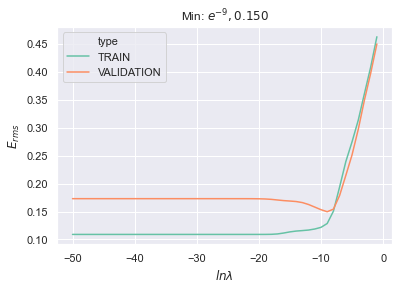

In [47]:
best_lambda, least_loss = show_lambda_error(error_ln_lambda)

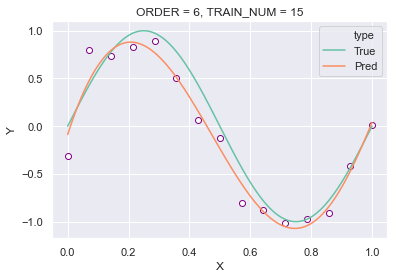

In [48]:
y_pred, w_vec = get_y_pred_by_analytical(x_train=X_TRAIN, y_train=Y_TRAIN, x=X_TEST, with_penalty=True, lambda_penalty=best_lambda)
W_SOLUTION["Analytical_With_Penalty"] = w_vec
show_comparation(x=X_TEST, y1=Y_TEST, label1="True", y2=y_pred, label2="Pred")
show_train_data(x_train=X_TRAIN, y_train=Y_TRAIN)

# 对比是否带惩罚项的拟合结果

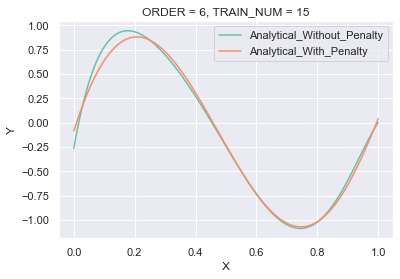

In [49]:
y_pred_without_penalty, w_wec_without_penalty = get_y_pred_by_analytical(
    x_train=X_TRAIN, y_train=Y_TRAIN, x=X_TEST, with_penalty=False
)
y_pred_with_penalty, w_wec_with_penalty = get_y_pred_by_analytical(
    x_train=X_TRAIN, y_train=Y_TRAIN, x=X_TEST, with_penalty=True, lambda_penalty=best_lambda,
)
show_comparation(
    x=X_TEST,
    y1=y_pred_without_penalty,
    label1="Analytical_Without_Penalty",
    y2=y_pred_with_penalty,
    label2="Analytical_With_Penalty",
)
plt.legend(["Analytical_Without_Penalty", "Analytical_With_Penalty"])

# 梯度下降法

In [50]:
def get_y_pred_by_gradient_descent(x_train, y_train, x, lambda_penalty):
    x_vec, t_vec = x_train, y_train
    k, w_vec = gradient_descent_fit(
        x_matrix=get_x_matrix(x_vec, order=ORDER),
        t_vec=t_vec,
        lambda_penalty=lambda_penalty,
        w_vec_0=np.zeros(ORDER + 1),
        learning_rate=LEARNING_RATE,
        delta=DELTA,
    )
    return k, np.dot(get_x_matrix(x, order=ORDER), w_vec), w_vec

In [51]:
k, y_pred, w_vec = get_y_pred_by_gradient_descent(
    x_train=X_TRAIN,
    y_train=Y_TRAIN,
    x=X_TEST,
    lambda_penalty=best_lambda,
)
W_SOLUTION["Gradient_Descent"] = w_vec
k

45026

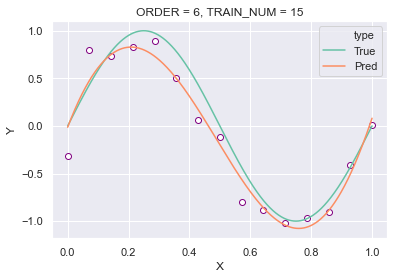

In [52]:
show_comparation(x=X_TEST, y1=Y_TEST, label1="True", y2=y_pred, label2="Pred")
show_train_data(x_train=X_TRAIN, y_train=Y_TRAIN)

# 共轭梯度法

In [53]:
def get_y_pred_by_conjugate_gradient(x_train, y_train, x, lambda_penalty):
    x_vec, t_vec = x_train, y_train
    A, x_0, b = switch_deri_func_for_conjugate_gradient(
        x_matrix=get_x_matrix(x_vec, order=ORDER),
        t_vec=t_vec,
        lambda_penalty=lambda_penalty,
        w_vec=np.zeros(ORDER + 1),
    )
    k, w_vec = conjugate_gradient_fit(A=A, x_0=x_0, b=b, delta=DELTA)
    return k, np.dot(get_x_matrix(x, order=ORDER), w_vec), w_vec

In [54]:
k, y_pred, w_vec = get_y_pred_by_conjugate_gradient(
    x_train=X_TRAIN,
    y_train=Y_TRAIN,
    x=X_TEST,
    lambda_penalty=best_lambda,
)
W_SOLUTION["Conjugate_Gradient"] = w_vec
k

5

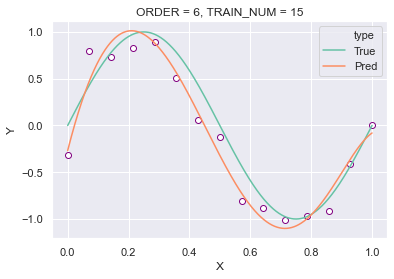

In [55]:
show_comparation(x=X_TEST, y1=Y_TEST, label1="True", y2=y_pred, label2="Pred")
show_train_data(x_train=X_TRAIN, y_train=Y_TRAIN)

In [56]:
W_SOLUTION

,Analytical_Without_Penalty,Analytical_With_Penalty,Gradient_Descent,Conjugate_Gradient
0,-0.263170,-0.087035,-0.013803,-0.268450
1,17.711819,9.854119,8.433307,12.821150
2,-92.945192,-26.797159,-22.119626,-33.749313
3,232.872936,5.489758,2.302150,2.911121
4,-365.327156,14.043467,11.887947,23.814990
5,312.046702,6.380782,6.676707,13.438940
6,-104.094835,-8.844513,-7.085864,-19.048898


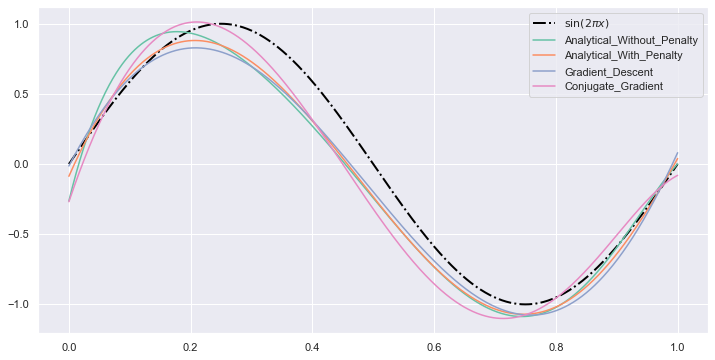

In [57]:
plt.figure(figsize=(12, 6))
show_test_data(x_test=X_TEST, y_test=Y_TEST)
for column in W_SOLUTION.columns:
    sns.lineplot(
        x=X_TEST,
        y=[W_SOLUTION[column] @ get_x_series(x=x, order=ORDER) for x in X_TEST],
    )
plt.legend(["$\sin (2 \pi x)$"] + list(W_SOLUTION.columns))